Rest of the time, executed from here

In [239]:
import matplotlib.pyplot as plot
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
from datetime import date
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.petri_net.utils.decomposition import decompose
from pm4py.objects.petri_net.utils import reachability_graph
from pm4py.visualization.transition_system import visualizer as ts_visualizer





Create one dataframe with the info from all EventLogs

In [211]:
folder="/home/jazmin/tuttifrutti/log/Tesis/EventLogs"
filenames = glob.glob(folder + "/*.csv")
dfs = []
model=0
for filename in filenames:
    log = pd.read_csv(filename, sep=',')
    case_id=[]
    case_id += len(log.mision) * ["mision "+str(model)]
    log['mision']=case_id
    model+=1
    dfs.append(log)
    big_frame = pd.concat(dfs, ignore_index=True)
    if model==len(filenames):
        big_frame.to_csv('/home/jazmin/tuttifrutti/log/Tesis/LogFinal/final_log_2.csv', sep=',', index=False)


Set the names for the colums in the dataframe

In [212]:
fn = '/home/jazmin/tuttifrutti/log/Tesis/LogFinal/final_log_2.csv'
events = pd.read_csv(fn)

events.columns = ['mision', 'action', 'datetime', 'resource', 'random_seed']
events['datetime'] = pd.to_datetime(events['datetime'])
events

,mision,action,datetime,resource,random_seed
0,mision 0,T_0_Busy,2023-09-10 10:04:36,0,45
1,mision 0,T_0_Done,2023-09-10 10:04:41,0,45
2,mision 0,T_1_Busy,2023-09-10 10:04:58,4,45
3,mision 0,T_1_Done,2023-09-10 10:05:03,4,45
4,mision 0,T_2_ocupied,2023-09-10 10:05:24,5,45
...,...,...,...,...,...
2377,mision 99,T_0_waiting,2023-09-10 10:07:56,3,57
2378,mision 99,T_0_busy,2023-09-10 10:07:56,3,57
2379,mision 99,T_1_busy,2023-09-10 10:07:56,5,57
2380,mision 99,T_0_done,2023-09-10 10:08:01,3,57


To use pm4py first we convert to an EventLog

In [213]:
eventlog = events.copy()
eventlog.rename(columns={'datetime': 'time:timestamp', 'mision': 'case:concept:name', 'action': 'concept:name', 'random_seed': 'org:resource'}, inplace=True)

## Convert to log format
log = log_converter.apply(eventlog)

To only get activities that happen fast from 0 to 200 seconds only

In [214]:

filtered_log = pm4py.filter_case_performance(log, 0, 100)
#filtered_log


/home/jazmin/.local/lib/python3.8/site-packages/pm4py/utils.py:494: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


We can check for the variants, there should be as many variants as concurrent activities

In [215]:
variants = pm4py.get_variants(log)
len(variants)
#variants

5

If we can to filter the log to the most usual variants we use:

In [216]:
k = 4
log_IDEAL = pm4py.filter_variants_top_k(log, k)

To check for the activities and the resources:
(You can alter if you want the resource to be the robot number or the random seed at line 48)

In [217]:
activities = pm4py.get_event_attribute_values(filtered_log, "concept:name")
resources = pm4py.get_event_attribute_values(filtered_log, "org:resource")

In [218]:
#activities

In [219]:
#resources

In [220]:
#You can get all the events containing a resource
tracefilter_log_pos = pm4py.filter_event_attribute_values(log, "org:resource", [7], level="event", retain=True)
#Or all the cases containing a resource
tracefilter_log_pos = pm4py.filter_event_attribute_values(log, "org:resource", [7], level="case", retain=True)

#change reatin to false to get all the events or cases not containing the resource 
tracefilter_log_pos

[{'attributes': {'concept:name': 'mision 35'}, 'events': [{'concept:name': 'T_0_Busy', 'time:timestamp': Timestamp('2023-09-10 10:03:32'), 'resource': 0, 'org:resource': 7, 'case:concept:name': 'mision 35'}, '..', {'concept:name': 'T_1_done', 'time:timestamp': Timestamp('2023-09-10 10:05:23'), 'resource': 5, 'org:resource': 7, 'case:concept:name': 'mision 35'}]}]

To check in detail the relationship between two activities we use between filter, we can check for the number of times the concurrent activities occur

In [221]:
filtered_log = pm4py.filter_between(log, "T_3_ocupied", "T_2_ocupied")
len(filtered_log)

26

To eliminate noise, we can eliminte logs that are too long (rework) or too short (incompleate)

In [222]:
filtered_log = pm4py.filter_case_size(log, 20, 24)
filtered_log

[{'attributes': {'concept:name': 'mision 0'}, 'events': [{'concept:name': 'T_0_Busy', 'time:timestamp': Timestamp('2023-09-10 10:04:36'), 'resource': 0, 'org:resource': 45, 'case:concept:name': 'mision 0'}, '..', {'concept:name': 'T_1_done', 'time:timestamp': Timestamp('2023-09-10 10:06:36'), 'resource': 3, 'org:resource': 45, 'case:concept:name': 'mision 0'}]}, '....', {'attributes': {'concept:name': 'mision 99'}, 'events': [{'concept:name': 'T_0_Busy', 'time:timestamp': Timestamp('2023-09-10 10:04:38'), 'resource': 0, 'org:resource': 57, 'case:concept:name': 'mision 99'}, '..', {'concept:name': 'T_1_done', 'time:timestamp': Timestamp('2023-09-10 10:08:01'), 'resource': 5, 'org:resource': 57, 'case:concept:name': 'mision 99'}]}]

To check for activities being excecuted more than k time we use

In [223]:
k=1
filtered_log = pm4py.filter_activities_rework(log, 'T_1_done', k)
print(filtered_log)

[{'attributes': {'concept:name': 'mision 0'}, 'events': [{'concept:name': 'T_0_Busy', 'time:timestamp': Timestamp('2023-09-10 10:04:36'), 'resource': 0, 'org:resource': 45, 'case:concept:name': 'mision 0'}, '..', {'concept:name': 'T_1_done', 'time:timestamp': Timestamp('2023-09-10 10:06:36'), 'resource': 3, 'org:resource': 45, 'case:concept:name': 'mision 0'}]}, '....', {'attributes': {'concept:name': 'mision 99'}, 'events': [{'concept:name': 'T_0_Busy', 'time:timestamp': Timestamp('2023-09-10 10:04:38'), 'resource': 0, 'org:resource': 57, 'case:concept:name': 'mision 99'}, '..', {'concept:name': 'T_1_done', 'time:timestamp': Timestamp('2023-09-10 10:08:01'), 'resource': 5, 'org:resource': 57, 'case:concept:name': 'mision 99'}]}]


To check for paths that take too long we use paths performance, so we get the list of paths taking longer than expected

In [224]:
filtered_log = pm4py.filter_paths_performance(log, ("T_1_Busy", "T_1_Done"), 0, 200)
filtered_log

[{'attributes': {'concept:name': 'mision 0'}, 'events': [{'concept:name': 'T_0_Busy', 'time:timestamp': Timestamp('2023-09-10 10:04:36'), 'resource': 0, 'org:resource': 45, 'case:concept:name': 'mision 0'}, '..', {'concept:name': 'T_1_done', 'time:timestamp': Timestamp('2023-09-10 10:06:36'), 'resource': 3, 'org:resource': 45, 'case:concept:name': 'mision 0'}]}, '....', {'attributes': {'concept:name': 'mision 99'}, 'events': [{'concept:name': 'T_0_Busy', 'time:timestamp': Timestamp('2023-09-10 10:04:38'), 'resource': 0, 'org:resource': 57, 'case:concept:name': 'mision 99'}, '..', {'concept:name': 'T_1_done', 'time:timestamp': Timestamp('2023-09-10 10:08:01'), 'resource': 5, 'org:resource': 57, 'case:concept:name': 'mision 99'}]}]

Now that we now how to extract relevant information by filtering the log, we can start modelling the log of the filtered logs behavior using process discovery


"Process Discovery algorithms want to find a suitable process model that describes the order of events/activities that are executed during a process execution."


ALPHA MINER
As we will see it has a tough time handeling the concurrent activities 

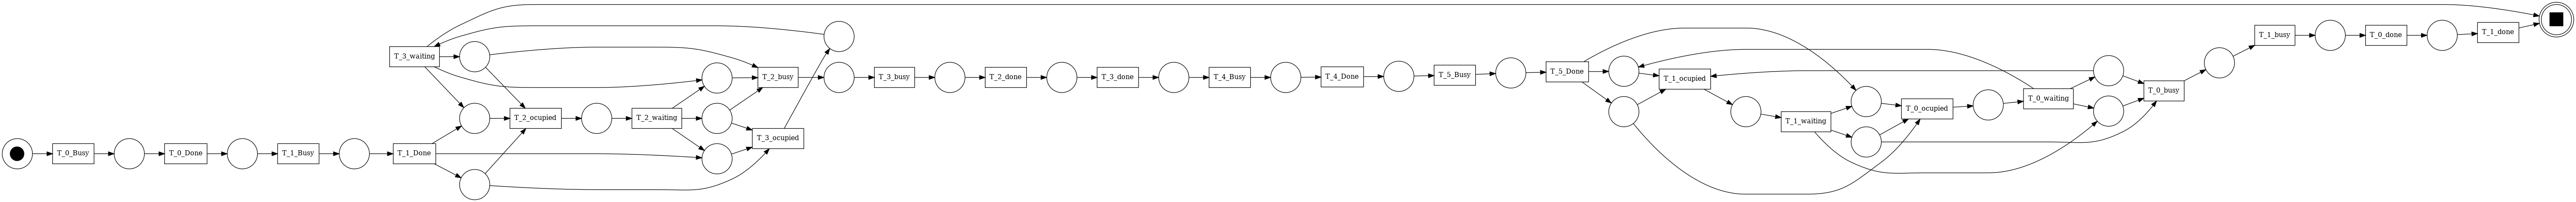

In [225]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(filtered_log)

pm4py.view_petri_net(net, initial_marking, final_marking)


INDUCTIVE MINER

This algorithim can be seen as a petri net, as a process tree and as a bpmn model.
According to the state of the art literature this alg should be the best at handeling the behaviour of a group of robots

/home/jazmin/.local/lib/python3.8/site-packages/pm4py/utils.py:494: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

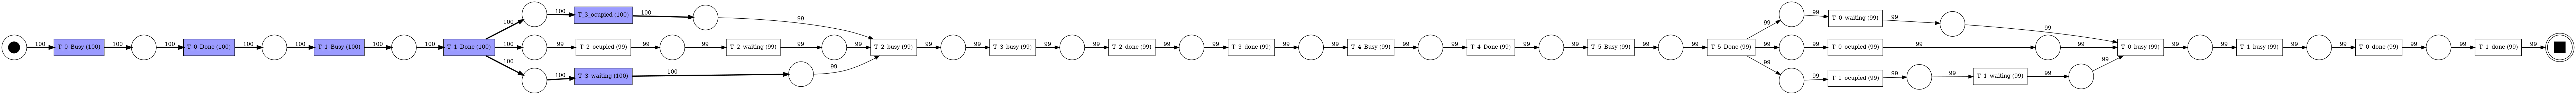

In [226]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log_IDEAL)
#pm4py.view_petri_net(net, initial_marking, final_marking)

#we can add frequency and performance, change the word to FREQUENCY or PERFORMANCE accordingly
parameters = {pn_visualizer.Variants.PERFORMANCE.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters, variant=pn_visualizer.Variants.FREQUENCY, log=log)
pn_visualizer.view(gviz)

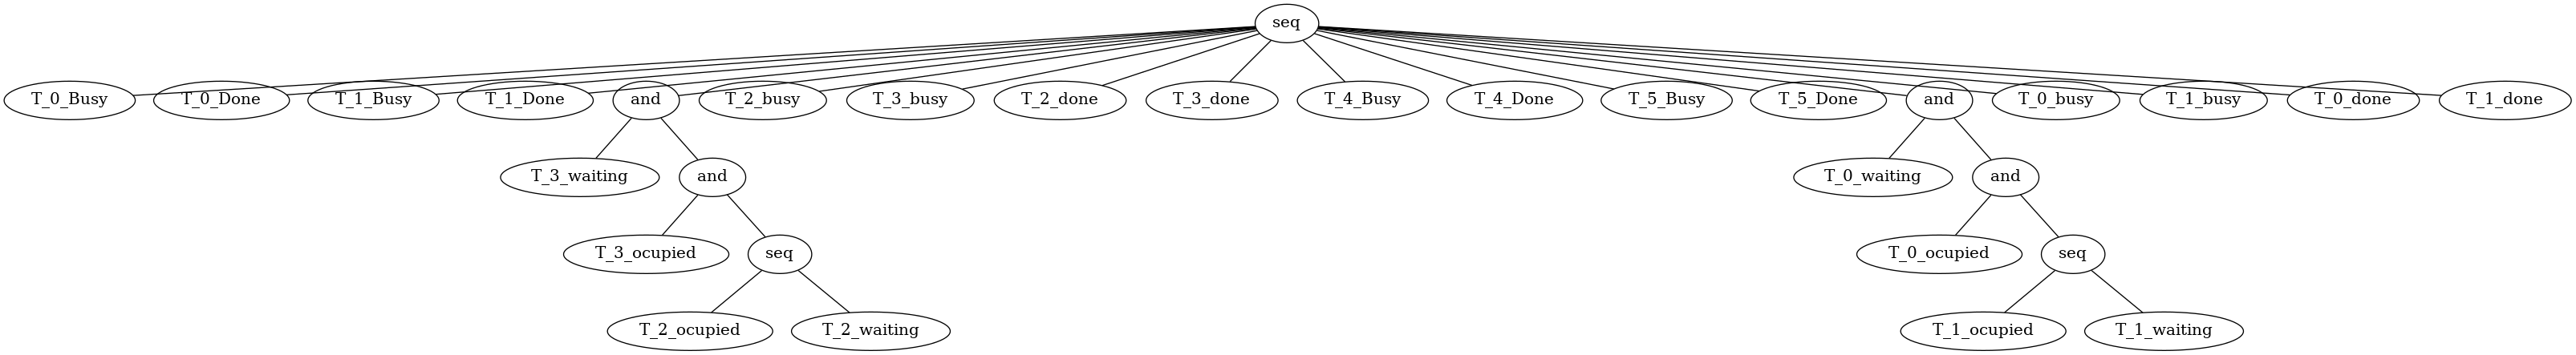

In [227]:
tree = pm4py.discover_process_tree_inductive(log_IDEAL)
pm4py.view_process_tree(tree)


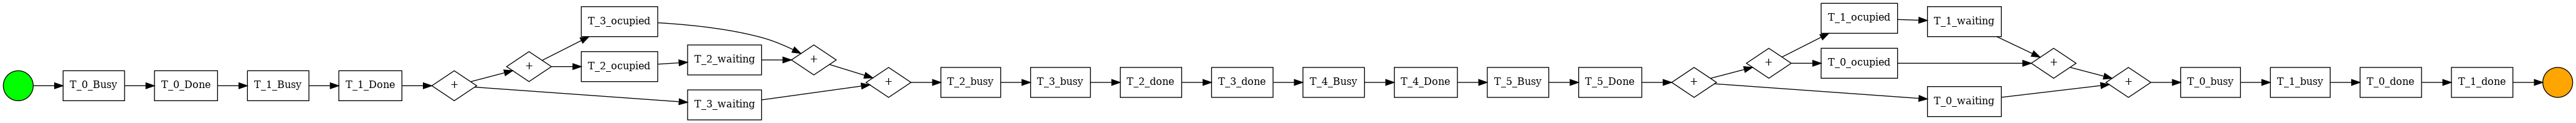

In [228]:
bpmn_graph = pm4py.discover_bpmn_inductive(log_IDEAL)
pm4py.view_bpmn(bpmn_graph)


    HEURISTIC MINER

    Heuristics Miner is an algorithm that acts on the Directly-Follows Graph, providing way to handle with noise and to find common constructs (dependency between two activities, AND).

    We will obtain a Heuristic net and a Petri Net

In [229]:
#Heuristic net
heu_net = pm4py.discover_heuristics_net(log_IDEAL, dependency_threshold=0.99)
#pm4py.view_heuristics_net(heu_net)

In [245]:
#Petri net
net, im, fm = pm4py.discover_petri_net_heuristics(log_IDEAL, dependency_threshold=0.99)
#pm4py.view_petri_net(net, im, fm)

ILP MINER

discovering Petri net using ILP miner, completed causal relations ::   0%|          | 0/31 [00:00<?, ?it/s]

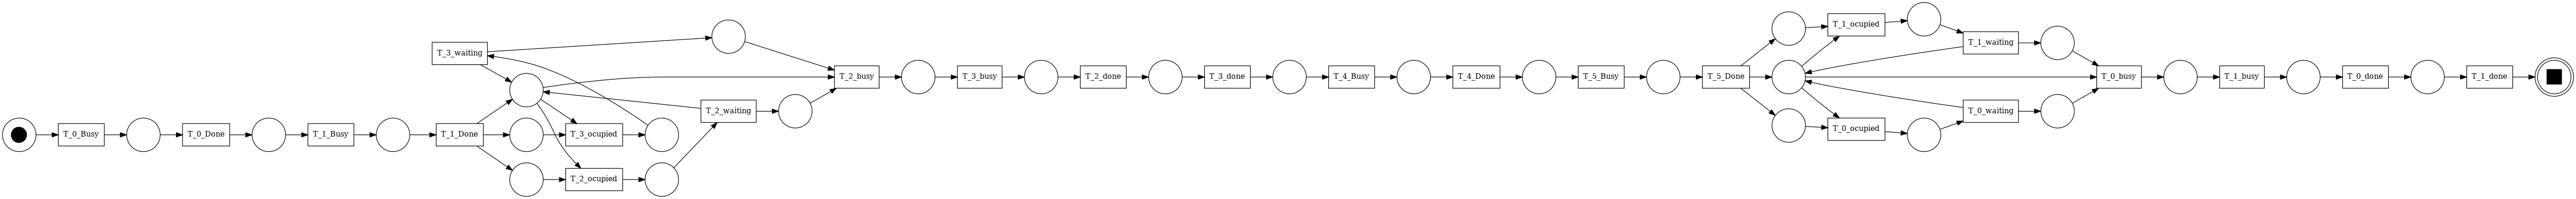

In [231]:
net, im, fm = pm4py.discovery.discover_petri_net_ilp(log_IDEAL)
pm4py.view_petri_net(net, im, fm)


In [232]:
dfg, start_activities, end_activities = pm4py.discover_dfg(log_IDEAL)
#pm4py.view_dfg(dfg, start_activities, end_activities)

In [233]:
performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(log_IDEAL)
#pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities)

We can decompose a petri net into smaller parts to make its avalisys easier

In [236]:

net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log_IDEAL)
list_nets = decompose(net, initial_marking, final_marking)
for index, model in enumerate(list_nets):
    subnet, s_im, s_fm = model
    #pm4py.view_petri_net(subnet, s_im, s_fm)

Reachability graph

 is the graph of all the markings of the Petri net. These markings are connected by as many edges as many transitions connect the two different markings

In [244]:
ts = reachability_graph.construct_reachability_graph(net, initial_marking)
gviz = ts_visualizer.apply(ts, parameters={ts_visualizer.Variants.VIEW_BASED.value.Parameters.FORMAT: "png"})
#ts_visualizer.view(gviz)
                            